# HATLAS-SGP master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on GAMA-09.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
atlas = Table.read("{}/ATLAS.fits".format(TMP_DIR))
kids = Table.read("{}/KIDS.fits".format(TMP_DIR))


## II - Merging tables



### ATLAS

In [5]:
master_catalogue = atlas
master_catalogue['atlas_ra'].name = 'ra'
master_catalogue['atlas_dec'].name = 'dec'

### Add KIDS

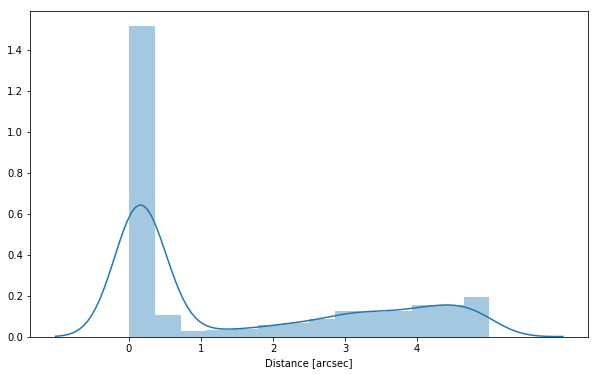

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(kids['kids_ra'], kids['kids_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, kids, "kids_ra", "kids_dec", radius=0.8*u.arcsec)

In [8]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['kids_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['atlas_id'].astype(str) )), 
                              name="omegacam_intid"))

## VI - Choosing between multiple values for the same filter

### ATLAS and KIDS
The ATLAS and KIDS surveys are both on the VLT Survey Telescope (VST). KIDS is significantly deeper so we take KIDS fluxes if available.

| Survey      | Bands observed   |
|-------------|------------------|
| ATLAS       | u, ul, griz      |
| KIDS        | ugri             |


In [9]:
omegacam_origin = Table()
omegacam_origin.add_column(master_catalogue['omegacam_intid'])

In [10]:
omegacam_stats = Table()
omegacam_stats.add_column(Column(data=['u', 'g','r','i'], name="Band"))
for col in ["ATLAS",  "KIDS"]:
    omegacam_stats.add_column(Column(data=np.full(4, 0), name="{}".format(col)))
    omegacam_stats.add_column(Column(data=np.full(4, 0), name="use {}".format(col)))
    omegacam_stats.add_column(Column(data=np.full(4, 0), name="{} ap".format(col)))
    omegacam_stats.add_column(Column(data=np.full(4, 0), name="use {} ap".format(col)))
    
#ul and z only in ATLAS so we can just rename those columns
for col in master_catalogue.colnames:
    if ('atlas_ul' in col) or ('atlas_z' in col):
        master_catalogue[col].name = col.replace('atlas', 'omegacam')

In [11]:
omegacam_bands = ['u','g','r','i']
for band in omegacam_bands:

    # omegacam total flux 
    has_kids = ~np.isnan(master_catalogue['f_kids_' + band])
    has_atlas  = ~np.isnan(master_catalogue['f_atlas_' + band])

    

    use_kids = has_kids
    use_atlas = has_atlas & ~has_kids


    f_omegacam = np.full(len(master_catalogue), np.nan)
    f_omegacam[use_kids] = master_catalogue['f_kids_' + band][use_kids]
    f_omegacam[use_atlas] = master_catalogue['f_atlas_' + band][use_atlas]
  

    ferr_omegacam = np.full(len(master_catalogue), np.nan)
    ferr_omegacam[use_kids] = master_catalogue['ferr_kids_' + band][use_kids]
    ferr_omegacam[use_atlas] = master_catalogue['ferr_atlas_' + band][use_atlas]

    
    m_omegacam = np.full(len(master_catalogue), np.nan)
    m_omegacam[use_kids] = master_catalogue['m_kids_' + band][use_kids]
    m_omegacam[use_atlas] = master_catalogue['m_atlas_' + band][use_atlas]
   

    merr_omegacam = np.full(len(master_catalogue), np.nan)
    merr_omegacam[use_kids] = master_catalogue['merr_kids_' + band][use_kids]
    merr_omegacam[use_atlas] = master_catalogue['merr_atlas_' + band][use_atlas]


    flag_omegacam = np.full(len(master_catalogue), False, dtype=bool)
    flag_omegacam[use_kids] = master_catalogue['flag_kids_' + band][use_kids]
    flag_omegacam[use_atlas] = master_catalogue['flag_atlas_' + band][use_atlas]


    master_catalogue.add_column(Column(data=f_omegacam, name="f_omegacam_" + band))
    master_catalogue.add_column(Column(data=ferr_omegacam, name="ferr_omegacam_" + band))
    master_catalogue.add_column(Column(data=m_omegacam, name="m_omegacam_" + band))
    master_catalogue.add_column(Column(data=merr_omegacam, name="merr_omegacam_" + band))
    master_catalogue.add_column(Column(data=flag_omegacam, name="flag_omegacam_" + band))

    old_kids_columns = ['f_kids_' + band,
                               'ferr_kids_' + band,
                               'm_kids_' + band, 
                               'merr_kids_' + band,
                               'flag_kids_' + band]
    old_atlas_columns = ['f_atlas_' + band,
                               'ferr_atlas_' + band,
                               'm_atlas_' + band, 
                               'merr_atlas_' + band,
                               'flag_atlas_' + band]

    
    old_columns = old_kids_columns + old_atlas_columns 
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_kids] = "kids"
    origin[use_atlas] = "atlas"
   
    
    omegacam_origin.add_column(Column(data=origin, name= 'f_omegacam_' + band ))
    
  
    # omegacam aperture flux 
    has_ap_kids = ~np.isnan(master_catalogue['f_ap_kids_' + band])
    has_ap_atlas  = ~np.isnan(master_catalogue['f_ap_atlas_' + band])
  
    

    use_ap_kids = has_ap_kids
    use_ap_atlas = has_ap_atlas & ~has_ap_kids


    f_ap_omegacam = np.full(len(master_catalogue), np.nan)
    f_ap_omegacam[use_ap_kids] = master_catalogue['f_ap_kids_' + band][use_ap_kids]
    f_ap_omegacam[use_ap_atlas] = master_catalogue['f_ap_atlas_' + band][use_ap_atlas]
  

    ferr_ap_omegacam = np.full(len(master_catalogue), np.nan)
    ferr_ap_omegacam[use_ap_kids] = master_catalogue['ferr_ap_kids_' + band][use_ap_kids]
    ferr_ap_omegacam[use_ap_atlas] = master_catalogue['ferr_ap_atlas_' + band][use_ap_atlas]
   
    
    m_ap_omegacam = np.full(len(master_catalogue), np.nan)
    m_ap_omegacam[use_ap_kids] = master_catalogue['m_ap_kids_' + band][use_ap_kids]
    m_ap_omegacam[use_ap_atlas] = master_catalogue['m_ap_atlas_' + band][use_ap_atlas]
   

    merr_ap_omegacam = np.full(len(master_catalogue), np.nan)
    merr_ap_omegacam[use_ap_kids] = master_catalogue['merr_ap_kids_' + band][use_ap_kids]
    merr_ap_omegacam[use_ap_atlas] = master_catalogue['merr_ap_atlas_' + band][use_ap_atlas]



    master_catalogue.add_column(Column(data=f_ap_omegacam, name="f_ap_omegacam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_omegacam, name="ferr_ap_omegacam_" + band))
    master_catalogue.add_column(Column(data=m_ap_omegacam, name="m_ap_omegacam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_omegacam, name="merr_ap_omegacam_" + band))


    old_ap_kids_columns = ['f_ap_kids_' + band,
                               'ferr_ap_kids_' + band,
                               'm_ap_kids_' + band, 
                               'merr_ap_kids_' + band]
    old_ap_atlas_columns = ['f_ap_atlas_' + band,
                               'ferr_ap_atlas_' + band,
                               'm_ap_atlas_' + band, 
                               'merr_ap_atlas_' + band]

    
    old_ap_columns = old_ap_kids_columns + old_ap_atlas_columns 
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_kids] = "kids"
    origin_ap[use_ap_atlas] = "atlas"
  
    
    omegacam_origin.add_column(Column(data=origin_ap, name= 'f_ap_omegacam_' + band ))

   
    omegacam_stats['KIDS'][omegacam_stats['Band'] == band] = np.sum(has_kids)
    omegacam_stats['ATLAS'][omegacam_stats['Band'] == band] = np.sum(has_atlas)

    omegacam_stats['use KIDS'][omegacam_stats['Band'] == band] = np.sum(use_kids)
    omegacam_stats['use ATLAS'][omegacam_stats['Band'] == band] = np.sum(use_atlas)

    omegacam_stats['KIDS ap'][omegacam_stats['Band'] == band] = np.sum(has_ap_kids)
    omegacam_stats['ATLAS ap'][omegacam_stats['Band'] == band] = np.sum(has_ap_atlas)
   
    omegacam_stats['use KIDS ap'][omegacam_stats['Band'] == band] = np.sum(use_ap_kids)
    omegacam_stats['use ATLAS ap'][omegacam_stats['Band'] == band] = np.sum(use_ap_atlas)

In [12]:
omegacam_stats.show_in_notebook()

idx,Band,ATLAS,use ATLAS,ATLAS ap,use ATLAS ap,KIDS,use KIDS,KIDS ap,use KIDS ap
0,u,1963,3,1963,3,17846,17846,17846,17846
1,g,7771,56,7771,56,25671,25671,25671,25671
2,r,2400,32,2400,32,27836,27836,27836,27836
3,i,12360,129,12360,129,25812,25812,25812,25812


In [13]:
omegacam_origin.write("{}/hatlas-sgp_omegacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## X - Saving the catalogue

In [14]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", "ebv"]

In [15]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'kids_flag_cleaned', 'atlas_flag_cleaned', 'kids_id', 'kids_stellarity', 'atlas_stellarity', 'omegacam_intid', 'kids_flag_gaia', 'atlas_flag_gaia', 'atlas_id'}


In [16]:
master_catalogue['ra'].name = 'omegacam_ra'
master_catalogue['dec'].name = 'omegacam_dec'
master_catalogue.write("{}/omegacam_merged_hatlas-sgp.fits".format(TMP_DIR), overwrite=True)